In [4]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import quandl
import seaborn as sns
import scipy.optimize as sco
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(777)
# Authenticate Quandl account
quandl.ApiConfig.api_key = "XXXXXXXXX


In [5]:
# define variables
stocks = ['EURONEXT/AF.4','EURONEXT/INGA.4','EURONEXT/DSM.4','EURONEXT/UNA.4']
start_date = '2016-01-01'
end_date = '2018-01-01'


In [6]:
# Import and select data
data = quandl.get(stocks, start_date = start_date,end_date = end_date)
print(data.head())


            EURONEXT/AF - Last  EURONEXT/INGA - Last  EURONEXT/DSM - Last  \
Date                                                                        
2016-01-04               7.250                12.200               45.155   
2016-01-05               7.490                12.215               46.020   
2016-01-06               7.550                12.015               45.020   
2016-01-07               7.581                11.775               43.865   
2016-01-08               7.676                11.525               43.850   

            EURONEXT/UNA - Last  
Date                             
2016-01-04               38.785  
2016-01-05               39.255  
2016-01-06               38.575  
2016-01-07               37.980  
2016-01-08               37.320  


In [7]:
# Rename columns
data.columns= ["KLM","ING","DSM","UNILEVER"]
print(data.head())

              KLM     ING     DSM  UNILEVER
Date                                       
2016-01-04  7.250  12.200  45.155    38.785
2016-01-05  7.490  12.215  46.020    39.255
2016-01-06  7.550  12.015  45.020    38.575
2016-01-07  7.581  11.775  43.865    37.980
2016-01-08  7.676  11.525  43.850    37.320


Text(0,0.5,'price in €')

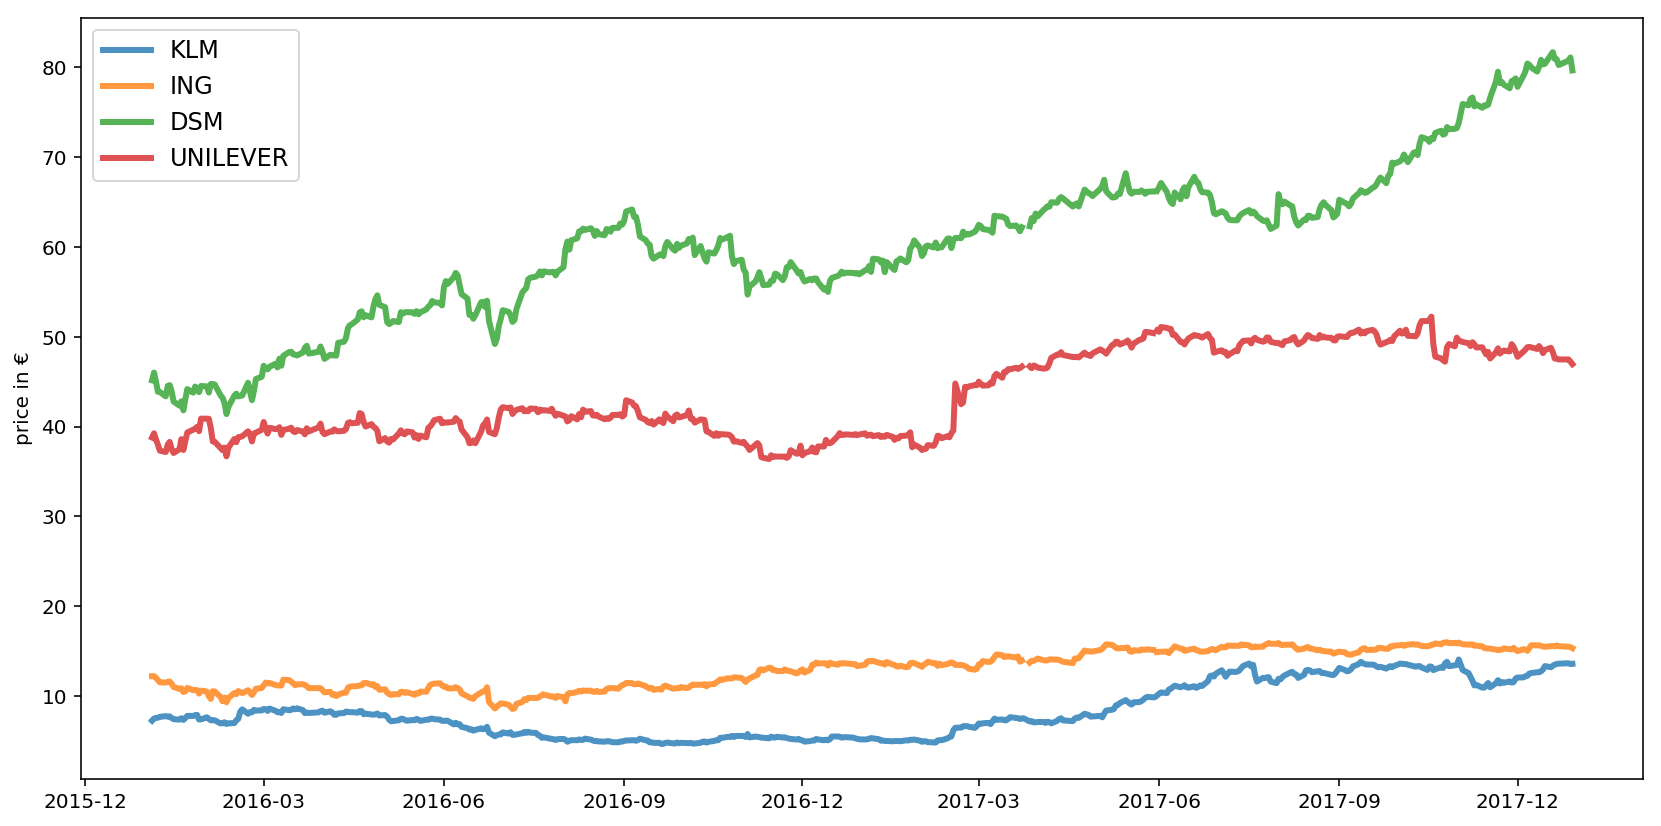

In [8]:
# Plot prices
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in €')

In [9]:
# Define returns
returns = data.pct_change()
print(returns.head())

                 KLM       ING       DSM  UNILEVER
Date                                              
2016-01-04       NaN       NaN       NaN       NaN
2016-01-05  0.033103  0.001230  0.019156  0.012118
2016-01-06  0.008011 -0.016373 -0.021730 -0.017323
2016-01-07  0.004106 -0.019975 -0.025655 -0.015424
2016-01-08  0.012531 -0.021231 -0.000342 -0.017378


Text(0,0.5,'return in %')

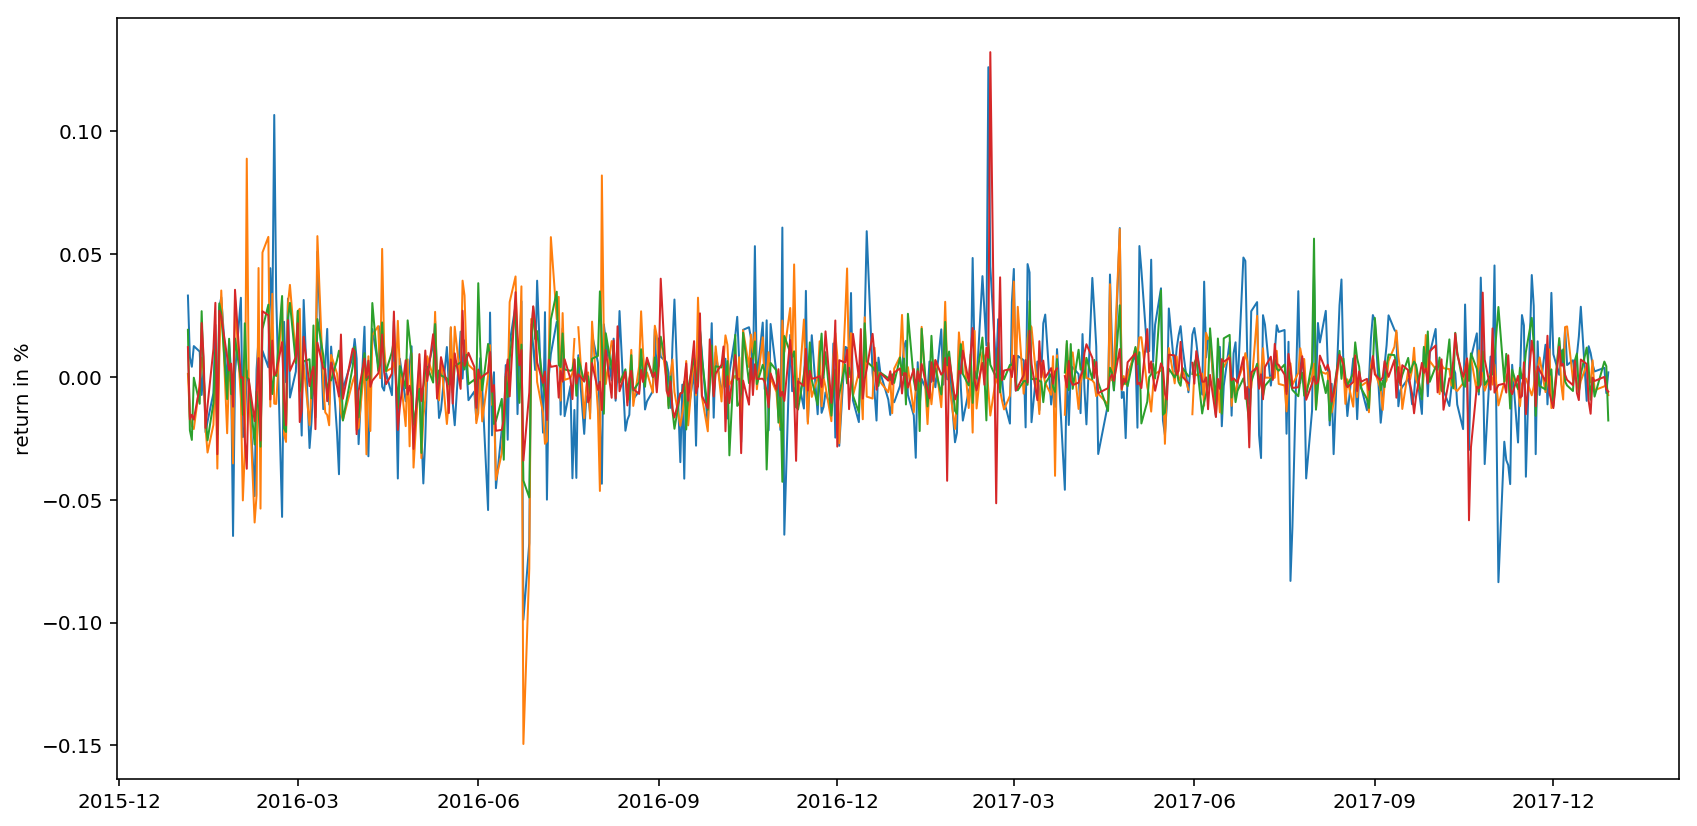

In [10]:
# Plot returns
plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index,returns[c],lw = 1,label = c)
plt.ylabel("return in %")

    

In [11]:
# Define annual return function

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix,risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights,mean_returns,cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate)/portfolio_std_dev
    return results, weights_record

In [12]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000
risk_free_rate = 0.00178

In [16]:
def display_simulated_ef_with_random(mean_returns,cov_matrix,num_portfolios,risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns,cov_matrix,risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index = data.columns,columns = ['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.plot([0,sdp],[risk_free_rate,rp])
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.31
Annualised Volatility: 0.19


              KLM   ING    DSM  UNILEVER
allocation  11.02  0.02  87.51      1.44
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.16


             KLM   ING    DSM  UNILEVER
allocation  5.39  7.07  44.66     42.89


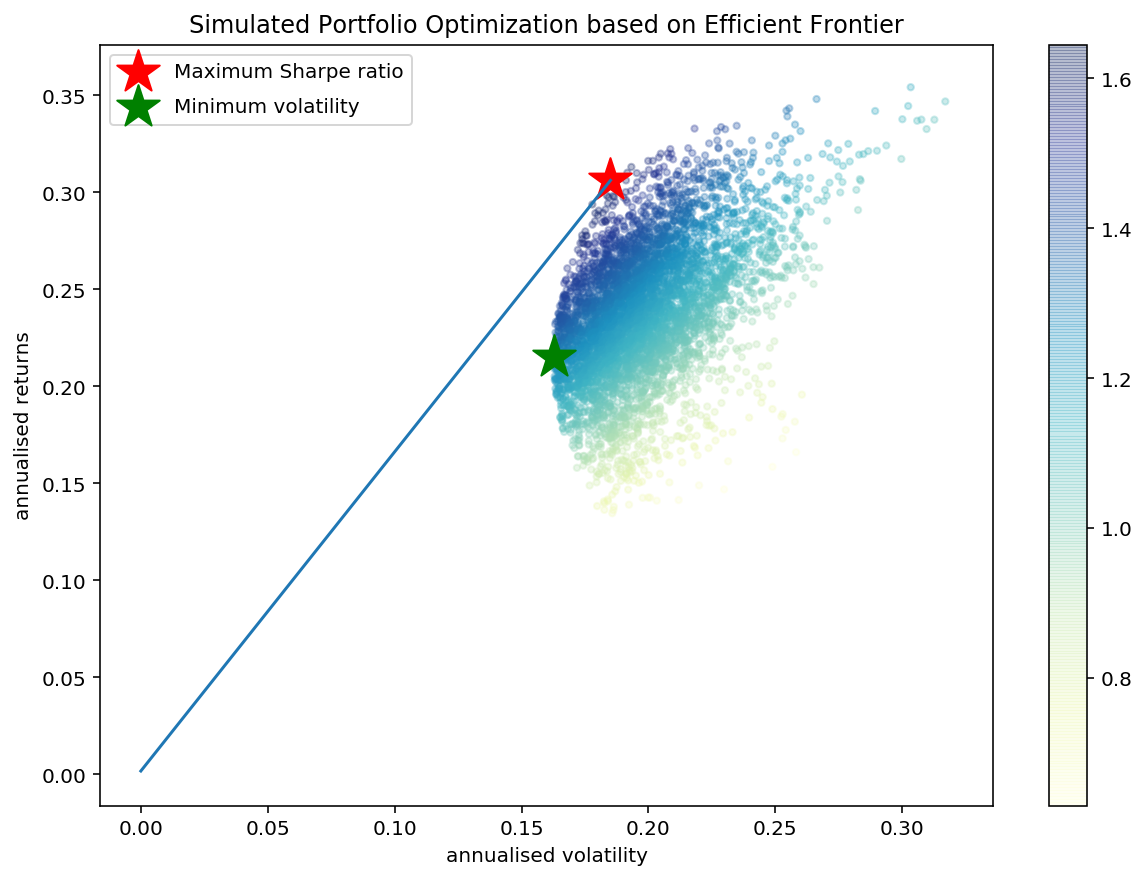

In [17]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)